# Modelo multinput

## Modelamiento 

Como primer paso vamos a importar las bibliotecas necesarias

In [25]:
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import argparse
import locale
import glob
import os
import shap

Nuestro propósito es **corroborar (o descartar) que agregar las fotos de los choques de autos asegurados permite una estimación más exacta de los montos, respecto del caso base que sólo usa información tabular**.
Para ello haremos uso de una red neuronal _multi input_.

Ya se hizo un trabajo detallado de exploración de los datos, el que se puede encontrar [acá](https://github.com/fedeos/Tesis-UAI/blob/master/EDA%20Tesis%20MIA.ipynb).

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4511041.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
1,img_4511041_180.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
2,img_4511041_270.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
3,img_4511041_90.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
4,img_4511208.jpg,A,32700.0,817.5,2026-05-30,28486.68,0,0.0


Nuestro propósito es contar con un modelo de regresión que relacione el daño (```Amount```) con el resto de las variables:
- Modelo 1: Usando solo fotografías
- Modelo 2: Usando fotografías y además las variables númericas y categóricas

In [7]:
df.dtypes

Image_path            object
Insurance_company     object
Cost_of_vehicle      float64
Min_coverage         float64
Expiry_date           object
Max_coverage         float64
Condition              int64
Amount               float64
dtype: object

In [8]:
df.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
count,1601.000000,1601.000000,1601.000000,1696.000000,1685.000000
mean,37790.318551,944.757964,15421.337189,0.766509,3391.451632
std,8944.723303,223.618083,11468.101665,0.423176,3262.359910
min,11100.000000,277.500000,2853.000000,0.000000,-999.000000
25%,30100.000000,752.500000,7953.000000,1.000000,325.000000
50%,37900.000000,947.500000,10578.000000,1.000000,3363.000000
75%,45400.000000,1135.000000,13403.000000,1.000000,5599.000000
max,53500.000000,1337.500000,46495.680000,1.000000,59844.000000


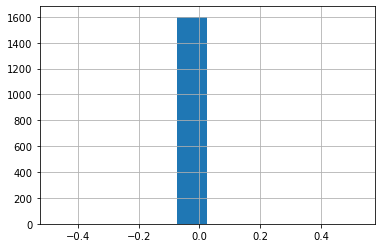

In [9]:
(df['Min_coverage']/df['Cost_of_vehicle']).hist();

In [10]:
df['Insurance_company'].value_counts()

B     172
BQ    167
A     165
AA    159
C     155
BB    154
O     153
DA    152
BC    151
AC    137
RE    131
Name: Insurance_company, dtype: int64

Se debe hacer notar que:
- La cobertura mínima es sistemáticamente el 25% del valor del automóvil, de modo que la variable no aporta información
- Creemos Sería razonable suponer que tanto la máxima cobertura (```Max_coverage```)  como el monto del daño (```Amount```) sean expresados como proporción del costo del vehículo
- Expresaremos ```Expiry_date```como días pendientes de cobertura a partir de una fecha nominal
- Notar que las compañías de seguros son 11 distintas

In [11]:
HOY = pd.to_datetime(datetime.date(2021,6,30)) # Fecha nominal para calcular los días de cobertura pendiente

In [12]:
df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4511041.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
1,img_4511041_180.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
2,img_4511041_270.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
3,img_4511041_90.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
4,img_4511208.jpg,A,32700.0,817.5,2026-05-30,28486.68,0,0.0


Generaremos una función ad hoc para contar con conjuntos de entrenamiento y validación.  El conjunto de prueba con que contamos no está etiquetado.
Los comentarios pertinentes se agregan en el código de la función.

In [13]:
def preprocesa_atributos(input_path):
    
    '''
    Dada la ruta a un archivo devuelve partición en conjuntos de entrenamiento y validación
    
    input: ruta a un archivo, el que debe contener en una el link a la foto.
    output: Conjuntos de entrenamiento y Validación, además de pd.Series con ruta a las imágenes
    
    
    '''
    
    df=pd.read_csv(input_path)
    df.dropna(inplace=True)
    df = df.drop(columns=['Condition']) # Queremos predecir el monto, por el momento no nos interesa
    df = df[(df['Amount']<=df['Cost_of_vehicle'])] #Filtramos casos: Monto del daño no debiera ser > valor auto
    
    df['Expiry_date']=pd.to_datetime(df['Expiry_date'])
    df['dias_pendientes_cobertura']=(df['Expiry_date']-HOY).dt.days.astype(int) #Permite contar días hasta fin cobertura
    df['relative_amount'] = df['Amount']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    df['relative_max_cov'] = df['Max_coverage']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    
    
    df = df.drop(columns=['Min_coverage','Expiry_date','Max_coverage','Amount'])
    
    scaler = MinMaxScaler() #Vamos a escalar variables numéricas
     
    
    X = df.drop(columns=['relative_amount'])
    y = df['relative_amount']
    
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=123)
    
    
    X_train_num = X_train[['Cost_of_vehicle','dias_pendientes_cobertura']]
    X_val_num = X_val[['Cost_of_vehicle','dias_pendientes_cobertura']]
    
    X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), 
                                      columns=X_train_num.columns,
                                      index=X_train.index)
    
    X_val_num_scaled = pd.DataFrame(scaler.transform(X_val_num), 
                                      columns=X_val_num.columns,
                                       index=X_val.index)
    
    lb = LabelBinarizer()# Codificaremos valores categóricos
    
    
    X_train_encoded = pd.DataFrame(lb.fit_transform(X_train['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_train.index)
    
    X_val_encoded = pd.DataFrame(lb.transform(X_val['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_val.index)
    
    
    X_train_feat = pd.concat([X_train['relative_max_cov'],X_train_num_scaled,X_train_encoded],axis=1)
    X_val_feat = pd.concat([X_val['relative_max_cov'],X_val_num_scaled,X_val_encoded],axis=1)
    
    X_train_im = X_train['Image_path']
    X_val_im = X_val['Image_path']
    
    
    return X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val
    

In [14]:
X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val = preprocesa_atributos('train.csv')

Dejo esta parte por si quisiera inspeccionar imágenes

In [15]:
pd.concat([X_train_feat,y_train],axis=1).head()

,relative_max_cov,Cost_of_vehicle,dias_pendientes_cobertura,A,AA,AC,B,BB,BC,BQ,C,DA,O,RE,relative_amount
198,0.252566,0.400000,0.014171,1,0,0,0,0,0,0,0,0,0,0,0.118158
1256,0.252532,0.410390,0.579854,0,0,1,0,0,0,0,0,0,0,0,0.014286
968,0.252005,0.620779,0.140942,1,0,0,0,0,0,0,0,0,0,0,0.089357
299,0.251477,0.981818,0.821907,0,0,0,0,0,0,0,1,0,0,0,0.009091
1000,0.252600,0.389610,0.592110,0,0,0,0,0,0,0,0,0,1,0,0.137367


## Entrenamiento de modelos

Para contar con una línea base, vamos a entrenar un modelo que solo usa los _features_ categóricos. Elegimos ```Random Forest```.

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
rfr = RandomForestRegressor(random_state = 777)
rfr.fit(X_train_feat,y_train)

RandomForestRegressor(random_state=777)

In [18]:
y_pred_rfr = rfr.predict(X_val_feat)

In [19]:
error_promedio_rfr = mean_absolute_error(y_val,y_pred_rfr)
error_promedio_rfr

0.05213814076488492

In [20]:
importancias_rf = pd.DataFrame(zip(X_train_feat.columns,rfr.feature_importances_),
                               columns = ['nombre','importancia']).sort_values(by='importancia',ascending=False)

En la siguiente tabla podemos obtener la importancia relativa de las variables

In [21]:
importancias_rf

,nombre,importancia
0,relative_max_cov,0.492418
2,dias_pendientes_cobertura,0.209415
1,Cost_of_vehicle,0.157764
6,B,0.015734
10,C,0.015314
8,BC,0.014422
7,BB,0.012717
11,DA,0.012648
4,AA,0.012506
3,A,0.012427


Parece lógico esperar que el porcentaje de cobertura máxima del vehículo, los días pendientes y el costo del vehículo puedan inducir al tasador / evaluador. Revisaremos los [Shapley Values](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a). 

In [22]:
shap_values = shap.TreeExplainer(rfr).shap_values(X_train_feat)

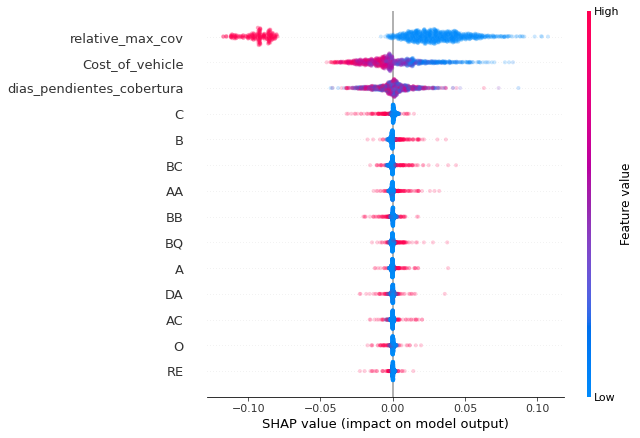

In [23]:
shap.summary_plot(shap_values,X_train_feat,alpha=0.2)

¿Qué pasa si usamos validación cruzada para chequear los resultados?

scores = cross_val_score(rfr, X, y, cv=5)

In [31]:
X = pd.concat([X_train_feat,X_val_feat],axis=0)
y = pd.concat([y_train,y_val],axis=0)

In [47]:
scores = -cross_val_score(rfr,X,y,cv=10,scoring='neg_mean_absolute_error')
scores

array([0.04676984, 0.0518355 , 0.0430425 , 0.04385761, 0.05452604,
       0.04806377, 0.05210996, 0.04798228, 0.05374202, 0.05136583])

In [46]:
np.mean(scores)

0.048859872356596924